In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statannot import add_stat_annotation

In [4]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 12  # width in inches
fig_height = 9  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
    },
)

sns.set_palette(sns.color_palette(nt_colors))

In [7]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']
# participant = all_participants[1]

# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac


In [15]:
df = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df = df.append(df_)
    
# df.to_csv('Data/all_markers.csv')

In [51]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
       'p_e_4', 'p_e_8', 'k', 'se', 'msf', 'sef90', 'sef95','b', 'b_n', 'g', 'g_n', 't', 't_n',
       'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b']
erps =['CNV', 'P1', 'P3a', 'P3b']


df_subtracted = df.query("preproc == 'subtracted'").drop(columns = erps+['preproc'])
df_erp = df.query("preproc == 'erp'").drop(columns = np.setdiff1d(markers,erps).tolist()+['preproc'])

df_markers = df_subtracted.merge(df_erp, 'inner', on =np.setdiff1d(df_subtracted.columns, markers).tolist() )

df_markers = (df_markers
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
            .query('prev_trial <= 4')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type'], axis = 1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )



In [33]:
df_agg = df_markers.groupby(['probe', 'mind', 'participant'], as_index = False).agg('mean')
df_melt = df_agg.melt(id_vars = ['probe', 'mind', 'participant'], var_name = 'markers', value_name = 'val')

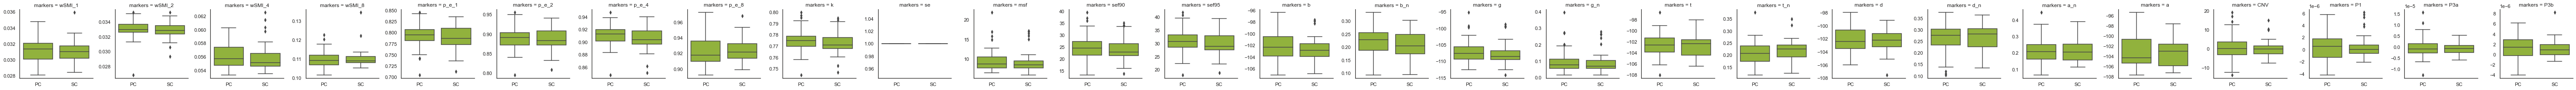

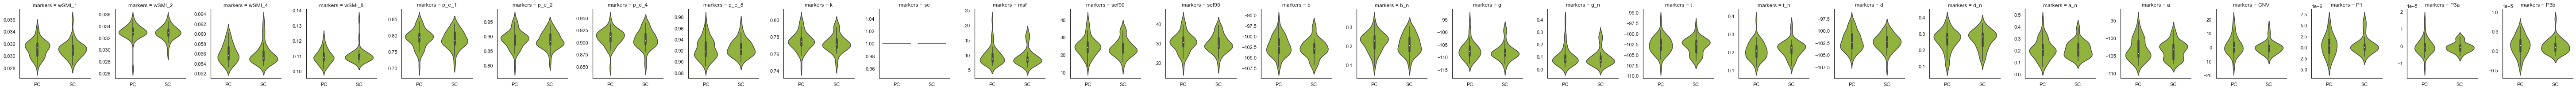

In [34]:
g = sns.FacetGrid(df_melt, col='markers', sharey = False)
g.map_dataframe(sns.boxplot, x='probe', y = 'val')
plt.show()

g = sns.FacetGrid(df_melt, col='markers', sharey = False)
ax = g.map_dataframe(sns.violinplot, x='probe', y = 'val')
plt.show()

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [65]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
)

df_mind.columns = df_mind.columns.map("_".join)

df_mind  = (df_mind
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_':'mind2'})
            .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) 
           )

df_mind = df_mind.drop(['se_mean', 'se_std'], axis = 1)

In [37]:
# df_mind.drop('mind2', axis =1 ).corr()

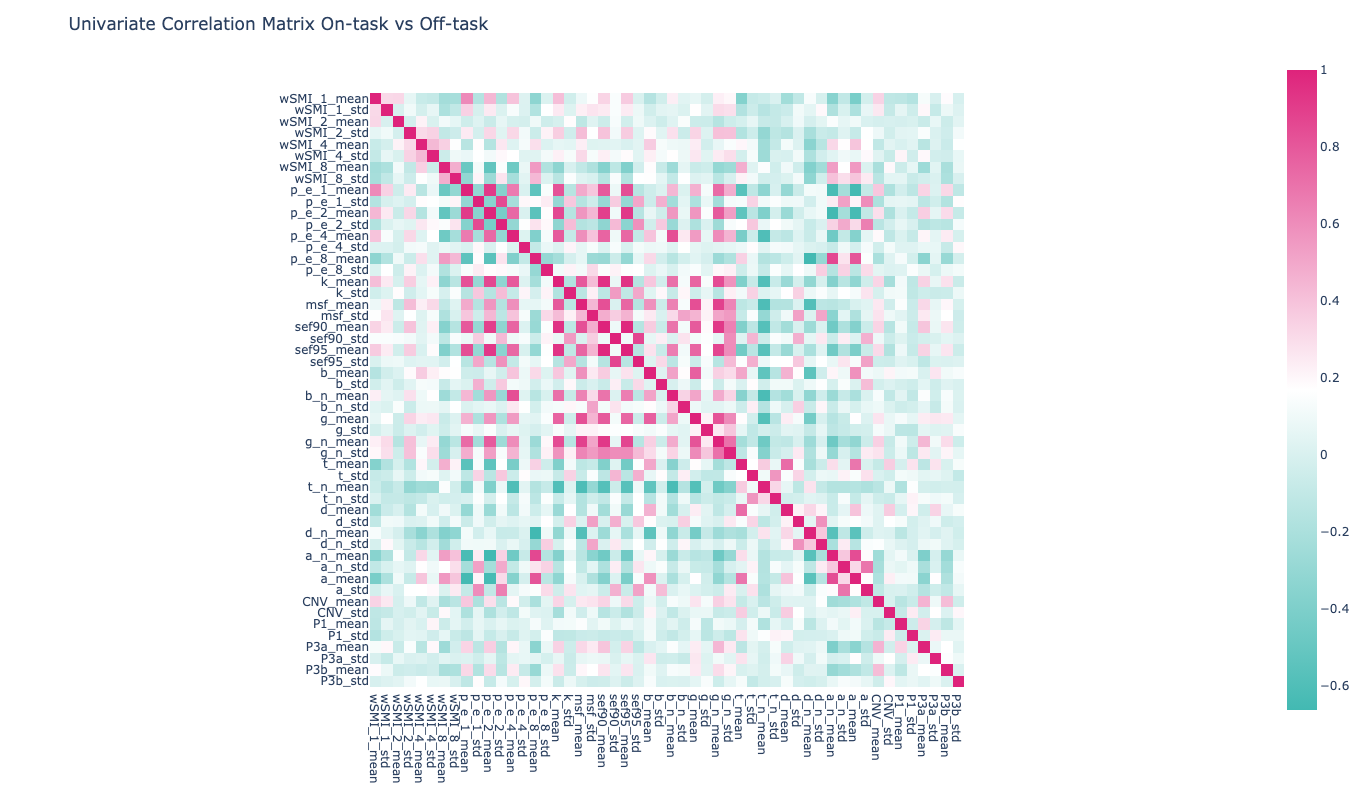

In [72]:
fig = px.imshow(df_mind.drop('mind2', axis =1 ).corr(),  color_continuous_scale=[(0,lblue), (0.5,'white'), (1,pink)] ,template = "plotly_white")

fig.update_layout(
    title= 'Univariate Correlation Matrix On-task vs Off-task ',
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        },
    xaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)
fig.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [68]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

df_mw.columns = df_mw.columns.map("_".join)

df_mw  = (df_mw
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
            .drop(['participant', 'probe', 'segment'], axis = 1) 
           )
df_mw = df_mw.drop(['se_mean', 'se_std'], axis = 1)

In [40]:
# df_mw.drop('mind', axis =1 ).corr()

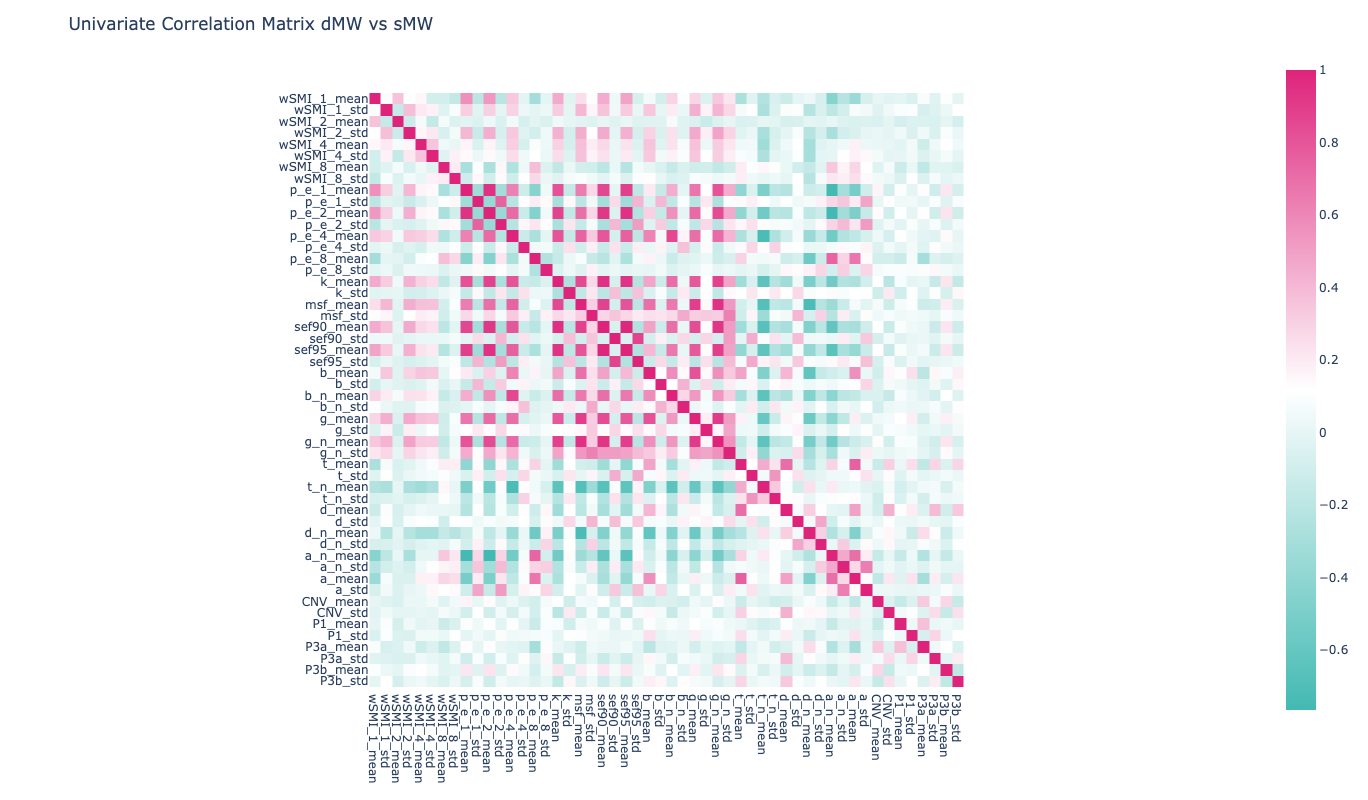

In [73]:
fig = px.imshow(df_mw.drop('mind', axis =1 ).corr(),  color_continuous_scale=[(0,lblue), (0.5,'white'), (1,pink)] ,template = "plotly_white")

fig.update_layout(
    title= 'Univariate Correlation Matrix dMW vs sMW',
    autosize=False,
    width=800,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        },
    xaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }
)
fig.show()